# Samplex Inputs and Outputs

## Introduction

{class}`~.Samplex` is the core type of the samplomatic library.
A samplex represents a parametric probability distribution over the
parameters of some template circuit, as well as other array-valued fields to use in
post-processing data collected from executing the bound template circuit. Its central interface 
is the {meth}`~.Samplex.sample` method that draws from this distribution to produce a
collection of arrays.

This guide is about using the {meth}`~.Samplex.sample` interface, how to query and specify required inputs, and how to inspect expected outputs.
The arrays supplied to and returned from {meth}`~.Samplex.sample` are strongly typed, in the
sense that for any particular instance of a samplex, their names, types, and shapes are fixed and queryable before any sampling is performed.
The various inputs and outputs present in a samplex depend on many factors so that we can't generally expect two samplex instances to have the same inputs and outputs as each other.

## Setup

To begin, we construct a boxed-up circuit and build it into a samplex and template pair to use in the examples that follow.
Note that while manually boxing up the circuit, we use the names `alpha`, `beta`, `noise1`, `noise2`, `mod_a`, `mod_b`, `abc`, and `conclude`, and moreover the circuit has four `Parameter`s.
This guide shows how each of these play a role in the samplex inputs and outputs.
See [the transpiler guide](./transpiler) for information about boxing up circuits automatically.

In [1]:
# Without this cell, plotly outputs do not appear in the docs. We hide this cell from itself being
# rendered in the docs by editing its metadata to contain the tags ["remove-input", "remove-output"]
import plotly.io as pio

pio.renderers.default = "sphinx_gallery"

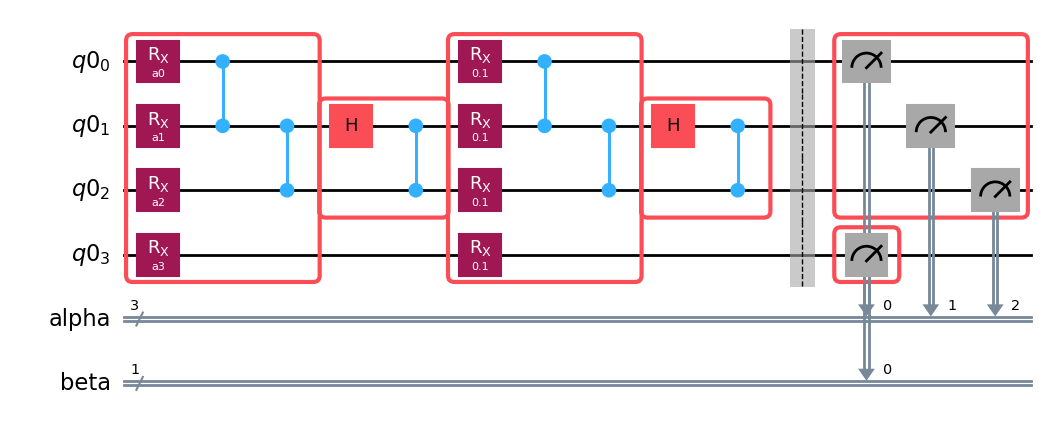

In [2]:
import numpy as np
from qiskit.circuit import ClassicalRegister, Parameter, QuantumCircuit, QuantumRegister
from qiskit.quantum_info import PauliLindbladMap

from samplomatic import BasisTransform, InjectNoise, Twirl, build

# our circuit has two classical registers named alpha and beta
circuit = QuantumCircuit(
    QuantumRegister(4), alpha := ClassicalRegister(3, "alpha"), beta := ClassicalRegister(1, "beta")
)

# the first box is only twirled
with circuit.box([Twirl()]):
    for idx in range(4):
        circuit.rx(Parameter(f"a{idx}"), idx)
    circuit.cz(0, 1)
    circuit.cz(1, 2)

# the second box is twirled, and has noise injected
with circuit.box([Twirl(), InjectNoise(ref="noise1", modifier_ref="mod_a")]):
    circuit.h(1)
    circuit.cz(1, 2)

# the third box is twirled, and has different noise injected
with circuit.box([Twirl(), InjectNoise(ref="noise2", modifier_ref="abc")]):
    circuit.rx(0.1, range(4))
    circuit.cz(0, 1)
    circuit.cz(1, 2)

# the fourth box is the same as the second, but with a different modifer ref
with circuit.box([Twirl(), InjectNoise(ref="noise1", modifier_ref="mod_b")]):
    circuit.h(1)
    circuit.cz(1, 2)

circuit.barrier()

# the final two boxes twirl, and add a basis transformation in one case
with circuit.box([Twirl(), BasisTransform(ref="conclude")]):
    circuit.measure(range(3), alpha)

with circuit.box([Twirl()]):
    circuit.measure([3], beta)

circuit.draw("mpl")

Next, we call {func}`~.build` on the boxed-up circuit to construct a template and samplex pair, and we see how each of the boxes is turned into a barrier-sandwich including `rz-sx-rz-sx-rz` fragments to implement dressing.

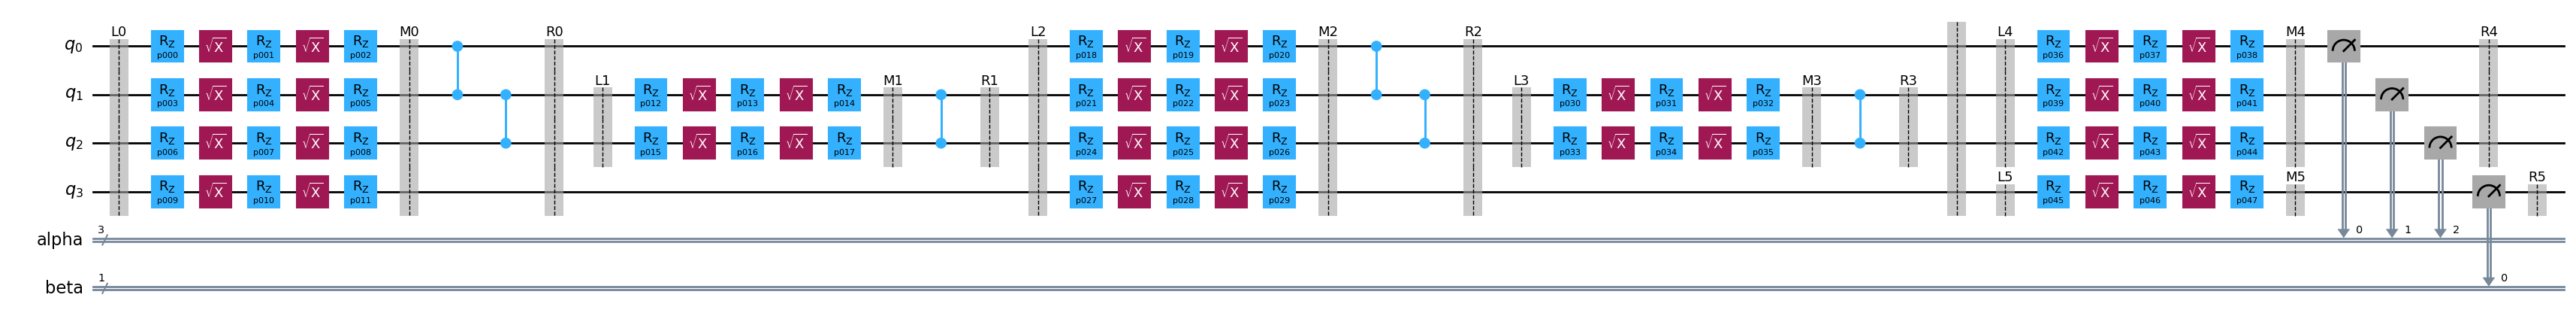

In [3]:
template, samplex = build(circuit)

template.draw("mpl", fold=100)

Plotting the samplex DAG and hovering over the nodes we see that all of the sampling nodes (stars) are responsible for generating randomizations for twirling, sampling from noise models, or injecting basis changes, and that all of the collection nodes (bow ties) are responsible for rendering slices of outputs, which are either measurement flips or parameter angles. The intermediate nodes (circles) are responsible for various kinds of data manipulation.

In [4]:
samplex.draw()

## Querying the required inputs and expected outputs

The easiest way to see the required inputs and expected outputs is to print the {class}`~.Samplex` object. Array items are formatted as `'{name}' <{type}[{shape}...]>`, and the required inputs precede the optional inputs.

In [5]:
print(samplex)

Samplex(<57 nodes>)
  Inputs:
  - 'basis_changes.conclude' <uint8[3]>: Basis changing gates, in the symplectic ordering
      I=0, Z=1, X=2, and Y=3.
  - 'parameter_values' <float64[4]>: Input parameter values to use during sampling.
  - 'pauli_lindblad_maps.noise1' <PauliLindbladMap>: A PauliLindblad map acting on 2 qubits,
      with 'num_terms_noise1' terms.
  - 'pauli_lindblad_maps.noise2' <PauliLindbladMap>: A PauliLindblad map acting on 4 qubits,
      with 'num_terms_noise2' terms.

  - 'local_scales.abc' <float64['num_terms_noise2']>: (Optional) An array of factors by which
      to scale individual rates of a Pauli Lindblad map, where the order should match the
      corresponding list of terms.
  - 'local_scales.mod_a' <float64['num_terms_noise1']>: (Optional) An array of factors by
      which to scale individual rates of a Pauli Lindblad map, where the order should match the
      corresponding list of terms.
  - 'local_scales.mod_b' <float64['num_terms_noise1']>: (Optional

The {meth}`~.Samplex.inputs` and {meth}`~.Samplex.outputs` of the samplex, as well as more detailed information like their names, shapes, types, and descriptions, can also be queried programatically. The return type of both of these methods is a {class}`~.TensorInterface`. For example, we list here all specifications of the input interface:

In [6]:
samplex.inputs().specs

[TensorSpecification('basis_changes.conclude', (3,), dtype('uint8'), 'Basis changing gates, in the symplectic ordering I=0, Z=1, X=2, and Y=3. '),
 TensorSpecification('local_scales.abc', ('num_terms_noise2',), dtype('float64'), 'An array of factors by which to scale individual rates of a Pauli Lindblad map, where the order should match the corresponding list of terms.', optional=True),
 TensorSpecification('local_scales.mod_a', ('num_terms_noise1',), dtype('float64'), 'An array of factors by which to scale individual rates of a Pauli Lindblad map, where the order should match the corresponding list of terms.', optional=True),
 TensorSpecification('local_scales.mod_b', ('num_terms_noise1',), dtype('float64'), 'An array of factors by which to scale individual rates of a Pauli Lindblad map, where the order should match the corresponding list of terms.', optional=True),
 TensorSpecification('noise_scales.abc', (), dtype('float64'), 'A scalar factor by which to scale rates of a Pauli Lindb

Next, as an example, we choose to print some information about those output specifiers whose names contain the string `"flips"`.

In [7]:
for spec in samplex.outputs().get_specs("flips"):
    print(spec.name, spec.shape, spec.dtype)

measurement_flips.alpha ('num_randomizations', 1, 3) bool
measurement_flips.beta ('num_randomizations', 1, 1) bool


## Binding input values and sampling

In order to {meth}`~.Samplex.sample`, the samplex needs to be provided with values for at least those {meth}`~.Samplex.inputs` that are marked as required.
These values are first bound to an input interface so that it can perform all necessary type checking (or type coercion in some cases) and shape analysis. 
If anything is wrong with the types or shapes, or if a required value is missing, a verbose error is raised.

### Binding Input

In the following example, we pass the {meth}`~.Samplex.sample` method its bare minimum requirements, and use it to draw 3 randomizations from the samplex.
The required bindings arising from the dressings are the Pauli Lindblad maps for noise injection and the basis change array. In addition to these, values for the four parameters in the original boxed-up circuit are required, which in this case we set to `np.linspace(0, 1, 4)`. The samplex will compose these parameters into the dressings, so that they effectively end up as modifications to the output parameter values of the samplex.


In [8]:
inputs = samplex.inputs().bind(
    # bind() concatenates nested dicts with a '.' so that we can
    # set 'pauli_lindblad_maps.noise0/1' as follows. note that the
    # names noise1 and noise2 derive from the names in the InjectNoise
    # annotation.
    pauli_lindblad_maps={
        "noise1": PauliLindbladMap.identity(2),
        "noise2": PauliLindbladMap.identity(4),
    },
    # likewise, we can set all basis changes as follows, where
    # the name 'conclude' comes from our basis change annotation
    basis_changes={"conclude": [0, 1, 2]},
    # we must provide values for all parameters in the original circuit
    parameter_values=np.linspace(0, 1, 4),
)

outputs = samplex.sample(inputs, num_randomizations=3)
print(outputs)

SamplexOutput(<
  - Dimension constraints: num_randomizations=3

  * 'measurement_flips.alpha' <bool['num_randomizations', 1, 3]>: Bit-flip corrections for
      measurement twirling.
  * 'measurement_flips.beta' <bool['num_randomizations', 1, 1]>: Bit-flip corrections for
      measurement twirling.
  * 'parameter_values' <float32['num_randomizations', 48]>: Parameter values valid for an
      associated template circuit.
  * 'pauli_signs' <bool['num_randomizations', 3]>: Signs from sampled Pauli Lindblad maps.
      The order matches the iteration order of injected noise in the circuit.
>)


Inputs can be bound to the interface through multiple calls to {meth}`~.TensorInterface.bind` or by direct item assignment.
Despite the nested dictionary format that {meth}`~.TensorInterface.bind` allows for convenience, it is a flat mapping object, and supports all of the usual mapping syntax.
Once all required inputs have been found, {attr}`~.TensorInterface.fully_bound` becomes true.

In [9]:
inputs = (
    samplex.inputs()
    .bind(
        pauli_lindblad_maps={
            "noise1": PauliLindbladMap.identity(2),
            "noise2": PauliLindbladMap.identity(4),
        }
    )
    .bind(parameter_values=np.linspace(0, 1, 4))
)

# once the final requirement is bound, fully_bound becomes True
print("Fully bound?", inputs.fully_bound)
inputs["basis_changes.conclude"] = [0, 2, 3]
print("Fully bound?", inputs.fully_bound)

# setting optional values does not affect whether the interface is fully bound
inputs["noise_scales.abc"] = 3
print("Fully bound?", inputs.fully_bound)

Fully bound? False
Fully bound? True
Fully bound? True


All {class}`~.TensorIterface` objects, including the {class}`~.SamplexOutput` subclass, are mapping objects against data that has been bound to them.
This means that we can get, for example, the template parameter values as follows, which in this case has shape `(3, 48)` since we asked for 3 randomizations and the template circuit has 48 parameters.

In [10]:
print("(num_randomizations, num_template_params) =", outputs["parameter_values"].shape)
print(outputs["parameter_values"][0, :])

(num_randomizations, num_template_params) = (3, 48)
[ 3.1415927  3.1415927  0.        -1.5707964  2.8082592 -1.5707964
  1.5707964  0.6666667  1.5707964  1.5707964  1.        -1.5707964
  0.         1.5707964  0.         1.5707964  3.1415927 -1.5707964
  1.5707964  0.1       -1.5707964 -1.5707964  0.1        1.5707964
  1.5707964  0.1        1.5707964  1.5707964  3.0415926  1.5707964
  3.1415927  1.5707964  0.         0.         0.         3.1415927
  0.         0.         3.1415927 -1.5707964  3.1415927  1.5707964
  3.1415927  1.5707964  3.1415927  3.1415927  3.1415927  0.       ]


### Input Types

Presently, there are two distinct interface value types, though this may grow:
 - Array-valued: These have a shape and a data type. Bound values are coerced into the data type if possible. Any dimension can be a free dimension.
 - Pauli Lindblad maps: These must be of type {class}`qiskit.quantum_info.PauliLindbladMap` and must act on the prescribed number of qubits. The number of terms in the map is a free dimension.

In [ ]:
# up to precision loss, these are equivalent via automatic type coersion of array inputs
samplex.inputs()["parameter_values"] = [1, 2, 8, 9]
samplex.inputs()["parameter_values"] = np.array([1, 2, 8, 9], dtype=np.float16)

### Free Dimensions

{class}`TensorInterface` has a notion of "free dimensions" which are named integer sizes whose values are undetermined until some data has been bound to the interface that constrains them.
All free dimensions of the same name must resolve to a consistent size when binding data or an error will be raised.
For example, in the {meth}`~.Samplex.outputs` of any samplex, the array axis corresponding to randomizations is a free parameter that has the name `"num_randomizations"` by convention.
When sample is called, it binds values to the outputs

In [11]:
print("All free dimensions:", outputs.free_dimensions)
print("Current constraints:", outputs.bound_dimensions)

All free dimensions: {'num_randomizations'}
Current constraints: {'num_randomizations': 3}


Another common free-dimension scenario is the sharing of term constraints between Pauli lindblad map specifications and their modifiers.
A {class}`qiskit.quantum_info.PauliLindbladMap` is an ordered sequence of terms, where each term contains a floating point rate and a sparse Pauli representation.
The {meth}`~.Samplex.build` method adds a specifier `"pauli_lindblad_maps.<ref>"` for this type for each {class}`~.InjectNoise` annotation, and if it contains a {attr}`~.InjectNoise.modifier_ref`,
then a `"local_scales.<modifier_ref>"` specifier is also added.
Both of these share the free dimension called `"num_terms_<ref>"` that specifies how many Pauli Lindblad terms are present in the noise model, for the latter needs to zip against the rates of the former in order to scale them.

In [22]:
# both the PauliLindbladMap and the local scales imply 2 terms, so that the free dimension
# 'num_terms_noise2' is satisfied
inputs = samplex.inputs().bind(
    pauli_lindblad_maps={"noise2": PauliLindbladMap.from_list([("XXYZ", 0.1), ("IIXX", 0.2)])},
    local_scales={"abc": [1, 2]},
)
print("All free dimensions:", inputs.free_dimensions)
print("Current constraints:", inputs.bound_dimensions)

All free dimensions: {'num_terms_noise1', 'num_terms_noise2'}
Current constraints: {'num_terms_noise2': 2}
